In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
names = open('names.txt', 'r').read().splitlines()

In [3]:
len(names) # number of inputs

32033

In [4]:
chars = [chr(c) for c in range(ord('a'), ord('z') + 1)]
chars.insert(0, '.')
s2i = {s:i for i,s in enumerate(chars)}
i2s = {i:s for s,i in s2i.items()}

In [5]:
vocab_size = len(i2s) # vocabulary size
print(vocab_size)

27


In [8]:
block_size = 3
def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for c in w + '.':
      ix = s2i[c]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


#Base MLP

In [ ]:
# MLP
embedding_size = 10
hidden_layers_size = 200

C = torch.randn((vocab_size, embedding_size),                       generator=g)
W1 = torch.randn((block_size * embedding_size, hidden_layers_size), generator=g) * (5/3) / ((block_size * embedding_size)**0.5) # * 0.2
# not needed because of the batch normalization layer introduced
#b1 = torch.randn(hidden_layers_size,                                generator=g) * 0.01
W2 = torch.randn((hidden_layers_size, vocab_size),                  generator=g) * 0.01
b2 = torch.randn(vocab_size,                                        generator=g) * 0

bngain = torch.ones((1, hidden_layers_size))
bnbias = torch.zeros((1, hidden_layers_size))

params = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in params)) # total number of params
for p in params:
  p.requires_grad = True

12297


##Gradient Descent

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  embedding = C[Xb]
  emb_cat = embedding.view(embedding.shape[0], -1)
  h_pre_act = emb_cat @ W1 #+ b1

  # batch normalization layer
  h_pre_act = bngain * (h_pre_act - h_pre_act.mean(0, keepdim=True)) / h_pre_act.std(0, keepdim=True) + bnbias

  h = torch.tanh(h_pre_act)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in params:
    p.data += -lr * p.grad

  # stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  #break

      0/ 200000: 3.3180
  10000/ 200000: 2.1205
  20000/ 200000: 2.4348
  30000/ 200000: 2.4123
  40000/ 200000: 2.5103
  50000/ 200000: 2.5178
  60000/ 200000: 2.1876
  70000/ 200000: 2.1194
  80000/ 200000: 1.9246
  90000/ 200000: 1.7623
 100000/ 200000: 2.1690
 110000/ 200000: 2.2706
 120000/ 200000: 2.3184
 130000/ 200000: 2.1007
 140000/ 200000: 2.2610
 150000/ 200000: 2.0215
 160000/ 200000: 1.9665
 170000/ 200000: 1.9598
 180000/ 200000: 2.0886
 190000/ 200000: 1.9548


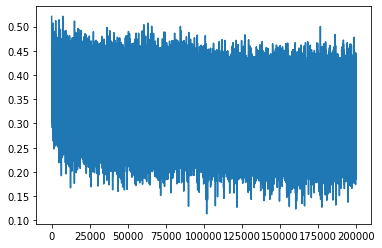

In [ ]:
plt.plot(lossi);

In [ ]:
@torch.no_grad()
def split_loss(s):
  x, y = {
      'train': (Xtr, Ytr),
      'dev': (Xdev, Ydev),
      'test': (Xte, Yte)
  }[s]

  emb = C[x]
  emb_cat = emb.view(emb.shape[0], -1)
  h_pre_act = emb_cat @ W1 + b1

  h_pre_act = bngain * (h_pre_act - h_pre_act.mean(0, keepdim=True)) / h_pre_act.std(0, keepdim=True) + bnbias

  h = torch.tanh(h_pre_act)
  logits = h @ W2 + b2

  loss = F.cross_entropy(logits, y)
  print(s, loss.item())

split_loss('train')
split_loss('dev')

train 2.068089723587036
dev 2.1075141429901123


##Initialization Neuron activation plots

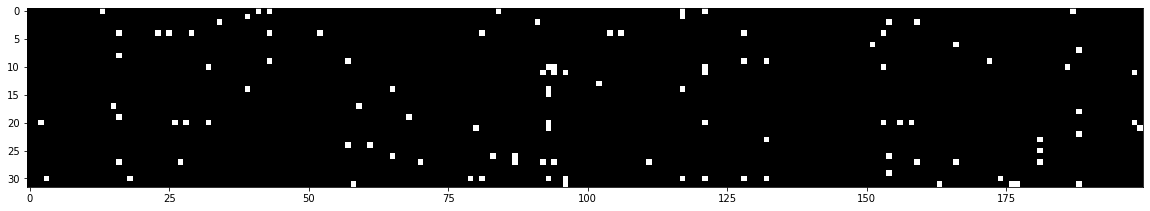

In [ ]:
# Neurons Activation
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

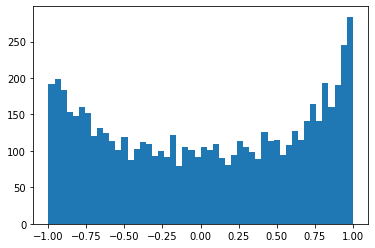

In [ ]:
# Activation histogram
plt.hist(h.view(-1).tolist(), 50);

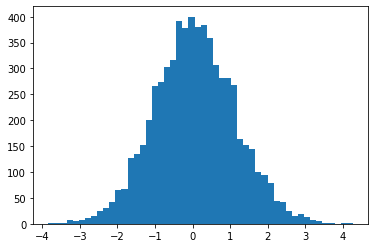

In [ ]:
# Pre activation histogram
plt.hist(h_pre_act.view(-1).tolist(), 50);

##Sampling

In [ ]:
sampling_g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    
    ix = torch.multinomial(probs, num_samples=1, generator=sampling_g).item()

    context = context[1:] + [ix]
    out.append(ix)

    if ix == 0:
      break
  
  print(''.join(i2s[i] for i in out))

carmah.
amorilli.
kimritheatleenanden.
jazonte.
deliah.
jareei.
ner.
kiah.
maiah.
kaleigh.
ham.
jory.
quinn.
sulisean.
adbi.
waythonielristin.
jenni.
sabee.
deciia.
gian.


#Toch-like MLP

In [82]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def params(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1D:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    # trainig parameters
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    # momentum update (buffers)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    # forward pass
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    # update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def params(self):
    return [self.gamma, self.beta]


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def params(self):
    return []


n_emb = 10 # embedding size
n_hidden = 100 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_emb), generator=g)

layers = [
    Linear(n_emb * block_size, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size), BatchNorm1D(vocab_size),
]

'''layers = [
    Linear(n_emb * block_size, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size)
]'''

with torch.no_grad():
  #layers[-1].weight *= 0.1 # for Linear Layer
  layers[-1].gamma *= 0.1 # Batch Normalization
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

params = [C] + [p for layer in layers for p in layer.params()]
print('Total number of parameters', sum(p.nelement() for p in params))
for p in params:
  p.requires_grad = True

Total number of parameters 47551


In [83]:
max_steps = 200000
batch_size = 32
lossi = []
u2d = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  #for layer in layers: # for plots
  #  layer.out.retain_grad() # for plots
  for p in params:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in params:
    p.data += -lr * p.grad

  # stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  with torch.no_grad():
    u2d.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in params])

  lossi.append(loss.log10().item())

  #if i == 1000:
  #  break

      0/ 200000: 3.3136
  10000/ 200000: 2.3016
  20000/ 200000: 2.3208
  30000/ 200000: 2.2122
  40000/ 200000: 2.2476
  50000/ 200000: 2.0265
  60000/ 200000: 2.1557
  70000/ 200000: 2.2830
  80000/ 200000: 1.8788
  90000/ 200000: 1.8509
 100000/ 200000: 2.0255
 110000/ 200000: 2.2019
 120000/ 200000: 2.4034
 130000/ 200000: 1.9753
 140000/ 200000: 2.0841
 150000/ 200000: 2.1819
 160000/ 200000: 1.9326
 170000/ 200000: 2.0584
 180000/ 200000: 2.0791
 190000/ 200000: 1.8565


##Plots and Histograms

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.59%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.19%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.12%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.66%


Text(0.5, 1.0, 'activation distribution')

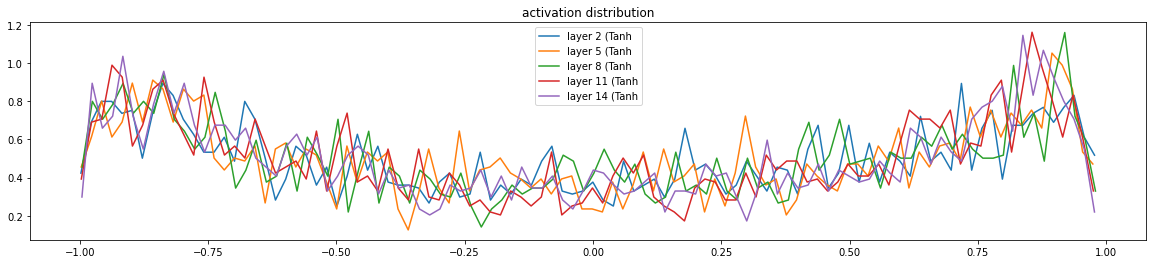

In [49]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.985768e-03
layer 5 (      Tanh): mean -0.000000, std 2.543702e-03
layer 8 (      Tanh): mean +0.000000, std 2.470582e-03
layer 11 (      Tanh): mean +0.000000, std 2.311888e-03
layer 14 (      Tanh): mean -0.000000, std 2.358913e-03


Text(0.5, 1.0, 'gradient distribution')

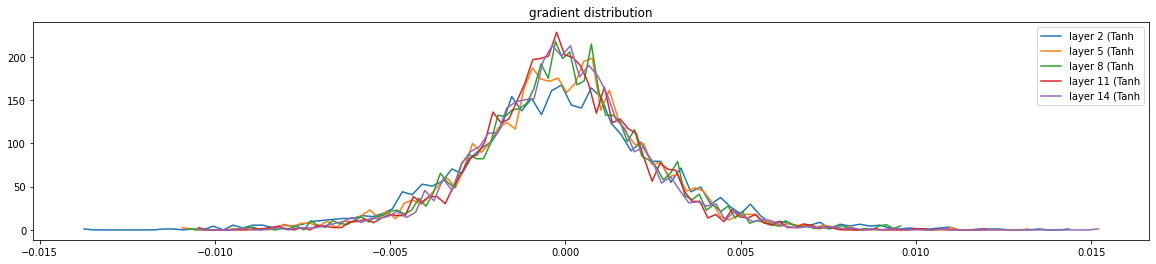

In [50]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.532060e-03 | grad:data ratio 8.523457e-03
weight  (30, 100) | mean +0.000056 | std 6.926509e-03 | grad:data ratio 2.216304e-02
weight (100, 100) | mean +0.000067 | std 5.648525e-03 | grad:data ratio 3.379710e-02
weight (100, 100) | mean -0.000042 | std 5.028825e-03 | grad:data ratio 2.982525e-02
weight (100, 100) | mean -0.000000 | std 4.746155e-03 | grad:data ratio 2.828118e-02
weight (100, 100) | mean -0.000004 | std 4.276122e-03 | grad:data ratio 2.547080e-02
weight  (100, 27) | mean +0.000019 | std 7.934636e-03 | grad:data ratio 4.761428e-02


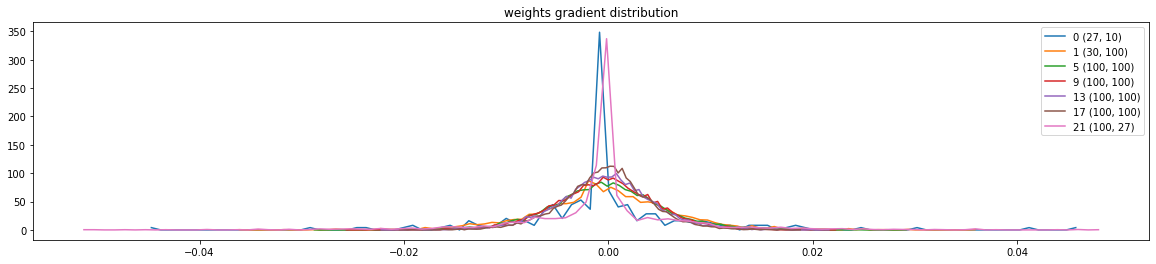

In [51]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(params):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

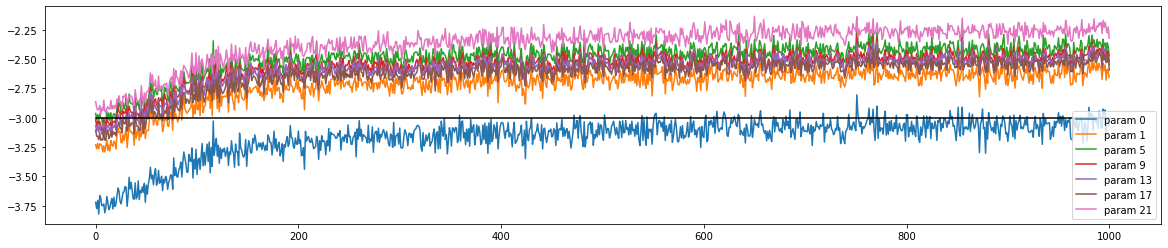

In [52]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(params):
  if p.ndim == 2:
    plt.plot([u2d[j][i] for j in range(len(u2d))])
    legends.append('param %d' % i)
plt.plot([0, len(u2d)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

##Sampling some examples

In [85]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False # needed or elese the batch norm layer will erase the calculated running mean and var
split_loss('train')
split_loss('val')

train 2.0115573406219482
val 2.101039409637451


In [86]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(i2s[i] for i in out)) # decode and print the generated word

carmahzabelle.
khyrmin.
remilahna.
sane.
rah.
bradherystina.
eil.
ramari.
chaiiv.
kaleigh.
ham.
joce.
quinthonor.
raiviani.
wavero.
dearyxi.
jace.
pinsley.
dae.
oia.
